In [1]:
import os

from os.path import join
from os import listdir

from tqdm import tqdm
import cv2
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from scipy import spatial


import math

import numpy as np

import torchvision
from torchvision import transforms
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
model.to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [4]:
keypoints = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

In [5]:
def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):
    # создаём спектр цветов
    
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img = img.squeeze().permute(1,2,0)
    img_copy = img.cpu().numpy().copy()
    #img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].cpu().detach().numpy().tolist())
                    )
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

In [6]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs


limbs = get_limbs_from_keypoints(keypoints)

In [7]:
def draw_limbs_per_person(
    img, all_keypoints, all_scores, confs, limbs, keypoint_threshold=2, conf_threshold=0.9
):
    # создаём спектр цветов
    
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    #img = img.squeeze().permute(1,2,0)
    #img_copy = img.cpu().numpy().copy()
    img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for lb in limbs:
                # проверяем степень уверенности детектора опорной точки
                if scores[lb[0]] > keypoint_threshold and scores[lb[1]] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint_0 = tuple(
                        map(int, keypoints[lb[0], :2].cpu().detach().numpy().tolist())
                    )
                    keypoint_1 = tuple(
                        map(int, keypoints[lb[1], :2].cpu().detach().numpy().tolist())
                    )
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.line(img_copy, keypoint_0, keypoint_1, color, 3)

    return img_copy

In [8]:
def extract_keypoint(all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    keypoints_all = []
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = list(
                        map(int, keypoints[kp, :2].cpu().detach().numpy().tolist())
                    )
                    
                keypoints_all.append(keypoint)        
        break  
    return keypoints_all

In [9]:
def cosine_distance(pose1, pose2):
    cossin = pose1.dot(np.transpose(pose2)) / (
        np.linalg.norm(pose1) * np.linalg.norm(pose2)
    )
    dist = cossin

    return dist


def weight_distance(pose1, pose2, conf1):
    # D(U,V) = (1 / sum(conf1)) * sum(conf1 * ||pose1 - pose2||) = sum1 * sum2

    sum1 = 1 / np.sum(conf1)
    sum2 = 0

    for i in range(len(pose1)):
        # каждый индекс i имеет x и y, у которых одинаковая оценка достоверности
        conf_ind = math.floor(i / 2)
        sum2 = conf1[conf_ind] * abs(pose1[i] - pose2[i])

    weighted_dist = sum1 * sum2

    return weighted_dist

In [10]:
def cosine_similarity(a, b):
# Вычисляем скалярное произведение
    dot_product = np.dot(a, np.transpose(b))

# Вычисляем нормы векторов
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

# Вычисляем косинусное сходство
    similarity = dot_product / (norm_a * norm_b)

    return similarity


In [11]:
ex = str(1)
print('exercise selected: ', ex)

exercise selected:  1


In [12]:
def delete_files(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f'Ошибка при удалении файла {file_path}. {e}')


In [13]:
path_coach = '/home/lexx/ComputerVision/diplom_2_1/diplom_2_1/data_input/coach/'
path_user = '/home/lexx/ComputerVision/diplom_2_1/diplom_2_1/data_input/user/'
count = 0
delete_files(path_user + 'frames/')
delete_files(path_coach + 'frames/')
videoFile_coach = path_coach + 'ex'+ ex +'.mp4'
dim = (640, 360)
cap_coach = cv2.VideoCapture(videoFile_coach)   # загрузка видео 
frameRate_coach = int(cap_coach.get(5)/2) # частота кадров
print(frameRate_coach)
x=1

while(cap_coach.isOpened()):
  frameId_coach = cap_coach.get(1) # номер текущего кадра
  ret, frame = cap_coach.read()
  if (ret != True):
      break
  elif (frameId_coach % math.floor(frameRate_coach) == 0):
      filename ="video1_%d.jpg" % count;count+=1
      full_filename = path_coach + 'frames/' + str(filename)
      
      # resize image
      resized_frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
      cv2.imwrite(full_filename, resized_frame)

cap_coach.release()
videoFile_user = path_user + 'ex'+ ex +'.mp4'

cap_user = cv2.VideoCapture(videoFile_user)   # загрузка видео 
frameRate_user = int(cap_user.get(5)/2) # частота кадров
print(frameRate_user)
x=1
count = 0
while(cap_user.isOpened()):
  frameId_user = cap_user.get(1) # номер текущего кадра
  ret, frame = cap_user.read()
  if (ret != True):
      break
  elif (frameId_user % math.floor(frameRate_user) == 0):
      filename ="video1_%d.jpg" % count;count+=1
      full_filename = path_user + 'frames/' + str(filename)
      resized_frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
      cv2.imwrite(full_filename, resized_frame)

cap_user.release()

11
11


In [14]:
imgs_model = []

for i in range(7):
    filename ="video1_%d.jpg" % i;i+=1
    full_filename_coach = path_coach + 'frames/' + str(filename)
    img_coach = Image.open(full_filename_coach).convert('RGB')
    transform = transforms.Compose([transforms.ToTensor()])
    img_coach = transform(img_coach).unsqueeze(0).to(device)
    imgs_model.append(img_coach)
    

In [15]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()  # Clear CUDA cache
torch.backends.cudnn.benchmark = True

In [16]:
all_preds_model = []

for i in range(len(imgs_model)):
    preds_model = model(imgs_model[i])
    all_preds_model.append(preds_model)
    torch.cuda.empty_cache()

    

In [17]:
imgs_input = []
for i in range(7):
    filename ="video1_%d.jpg" % i;i+=1
    full_filename_user = path_user + 'frames/' + str(filename)
    img_user = Image.open(full_filename_user).convert('RGB')
    transform = transforms.Compose([transforms.ToTensor()])
    img_user = transform(img_user).unsqueeze(0).to(device)
    imgs_input.append(img_user)

In [18]:
all_preds_input= []
for j in range(len(imgs_input)):
    preds_input = model(imgs_input[j])
    all_preds_input.append(preds_input)
    torch.cuda.empty_cache()

In [19]:
all_key_points_model = []
all_key_points_input = []
for i in range(len(all_preds_model)):
    current_key_points_model = extract_keypoint(all_preds_model[i][0]['keypoints'],all_preds_model[i][0]['keypoints_scores'], all_preds_model[i][0]['scores'])
    all_key_points_model.append(current_key_points_model)
for j in range(len(all_preds_input)):
    current_key_points_input = extract_keypoint(all_preds_input[j][0]['keypoints'],all_preds_input[j][0]['keypoints_scores'], all_preds_input[j][0]['scores'])
    all_key_points_input.append(current_key_points_input)
if len(all_key_points_model) == len(all_key_points_input):
    print(len(all_key_points_model))


7


In [1]:
def transform_keypoints(key_points_model, key_points_input):
    model_key_points = np.asarray(key_points_model)
    input_key_points = np.asarray(key_points_input)
 
# С помощью расширенной матрицы можно осуществить умножение вектора x на матрицу A и добавление вектора b за счёт единственного матричного умножения.
# Расширенная матрица создаётся путём дополнения векторов "1" в конце.
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:, :-1]
 
# Расширим наборы ключевых точек до [[ x y 1] , [x y 1]]
    Y = pad(model_key_points)
    X = pad(input_key_points)
# Решим задачу наименьших квадратов X * A = Y
# и найдём матрицу аффинного преобразования A.
    A, res, rank, s = np.linalg.lstsq(X, Y)
    A[np.abs(A) < 1e-10] = 0  # превратим в "0" слишком маленькие значения

# Теперь, когда мы нашли расширенную матрицу A,
# мы можем преобразовать входной набор ключевых точек
    transform = lambda x: unpad(np.dot(pad(x), A))
    input_transform = transform(input_key_points)
    return input_transform

In [21]:
def cosine_similarities(features_a, features_b):

# Вычисляем косинусное сходство для каждой пары векторов
    similarities = []
    similarities_mean = 0
    count = 1
    for i in range(len(features_a)):
        for j in range(len(features_b)):
            similarity = 1 - spatial.distance.cosine(features_a[i], features_b[j])
            similarities.append((i, j, similarity))
            similarities_mean += similarity
            count += 1

# Выводим результаты
    return similarities_mean/count

In [22]:
all_preds_input[i][0]['keypoints_scores']
cosine_sim = []
weight_dist = []
for i in range(len(all_key_points_model)):
    trans_input = transform_keypoints(all_key_points_model[i], all_key_points_input[i])
    current_cosine_sim = cosine_similarities(all_key_points_model[i], trans_input)
    current_weight_dist = weight_distance(all_key_points_model[i], trans_input, all_preds_input[i][0]['keypoints_scores'][0].cpu().detach().numpy().tolist())
    cosine_sim.append(current_cosine_sim)
    weight_dist.append(current_weight_dist)

In [23]:
print('Косинусное сходство')
for i in range(len(cosine_sim)):
    print(cosine_sim[i])
print('Взвешенное совпадение')
for j in range(len(weight_dist)):
    print(weight_dist[j])

Косинусное сходство
0.9878837971990142
0.9850468830631365
0.9868087902206099
0.9853114441421038
0.9920368496442522
0.9858654411963079
0.9844783517615142
Взвешенное совпадение
[0.34610059 0.98380898]
[0.17754897 0.2579525 ]
[0.43738469 0.9730117 ]
[0.9175225  0.02163025]
[1.10020732 2.45498343]
[0.34407985 0.89367793]
[0.02339907 0.44783011]


In [ ]:
len(all_preds_model)

In [25]:
def draw_frames(image, step):
    # Window name in which image is displayed
    window_name = 'Image'
    img = np.array(image)
    
    # text
    text1 = 'cosine_similarities: ' + str(cosine_sim[step])
    text2 = 'weight_distance: ' + str(weight_dist[step])
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX

    # org
    org1 = (5, 35)
    org2 = (5, 330)

    # fontScale
    fontScale = 1
 
    # Red color in BGR
    color = (255, 255, 255)

    # Line thickness of 2 px
    thickness = 2
 
    # Using cv2.putText() method
    img = cv2.putText(img, text1, org1, font, fontScale, color, thickness, cv2.LINE_AA, False)

    # Using cv2.putText() method
    img = cv2.putText(img, text2, org2, font, fontScale, color, thickness, cv2.LINE_AA, False) 

    # Displaying the image
    return img 

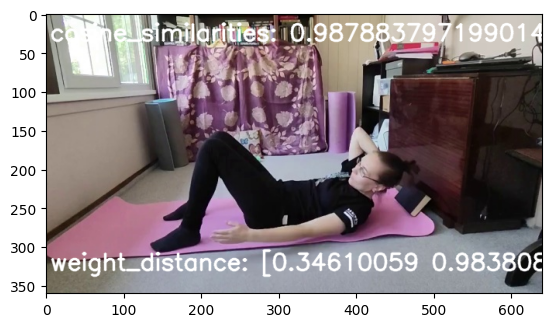

In [26]:
filename ="video1_0.jpg"
full_filename_user = path_user + 'frames/' + str(filename)
image = Image.open(full_filename_user).convert('RGB')
img_res = draw_frames(image, 0)
plt.imshow(img_res)

In [27]:
def show_images(images) -> None:
    n: int = len(images)
    f = plt.figure(figsize=(90, 60))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(n, 1, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)

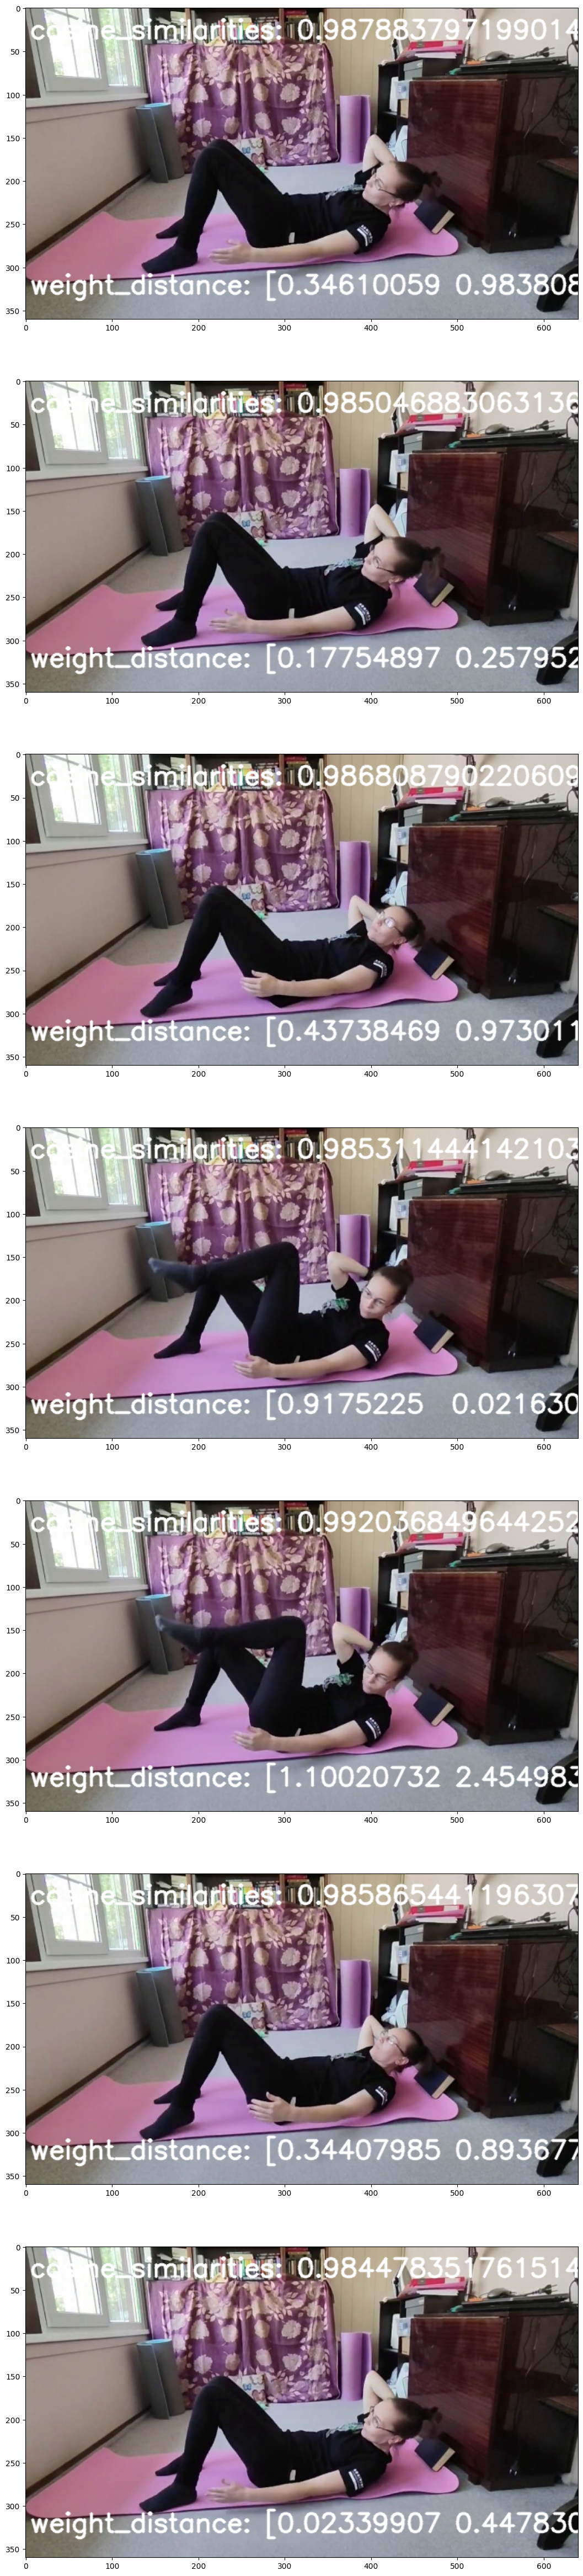

In [29]:
list_img = []
for i in range(7):
    filename ="video1_%d.jpg" % i;i+=1
    full_filename_user = path_user + 'frames/' + str(filename)
    img_user = Image.open(full_filename_user).convert('RGB')
    img_res = draw_frames(img_user, i-1)
    list_img.append(img_res)
show_images(list_img)